**Word Count**

This notebook aims to figure out common words in the text after a pre-computed sentiment analysis. 

We evaluate not only the overall text in general but within each sentiment caracterization - positive, negative and neutral. 

Also, corresponding word clouds are generated.


In [1]:
spark

# Initial settings

In [2]:
%%bash
# pip3 install -U textblob
# pip3 install wordcloud

In [3]:
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Text processing related imports

import re, string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [5]:
# some Spark related imports we will use hereafter

from pyspark.sql import SparkSession 
import pyspark.sql.functions as F 
from pyspark.sql.types import *

In [6]:
# Create Spark session if we want to

spark = SparkSession.builder.appName("ResettingSentimentAnalysisCommonWords").getOrCreate()

23/07/23 20:52:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Useful visualization functions

In [7]:
def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [8]:
def plotWordCloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

# Data ingestion

In [9]:
%%bash
# ls -la

In [10]:
# Read the data

df = spark.read.parquet("reviews-lexicon")  

In [11]:
# Check what has been read

df.printSchema()
reviews_count = df.count()
df.show(1, vertical=True, truncate=False)
reviews_count

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review text: string (nullable = true)
 |-- Collection-date: date (nullable = true)
 |-- Review-date: date (nullable = true)
 |-- Review-sentences-text: string (nullable = true)
 |-- Review-nouns-text: string (nullable = true)
 |-- Review-text-count: integer (nullable = true)
 |-- Review-sentences-text-count: integer (nullable = true)
 |-- Review-nouns-text-count: integer (nullable = true)
 |-- TextBlob-sentiment-score: map (nullable = true)
 |    |-- key: string
 |    |-- value: float (valueContainsNull = true)
 |-- TextBlob-sentiment: string (nullable = true)
 |-- Vader-sentiment-score: map (nullable = true)
 |    |-- key: string
 |    |-- value: float (valueContainsNull = true)
 |-- Vader-sentiment: string (nullable = true)

-RECORD 0-------------------------------------------------------

201

In [12]:
# Check counting with/without nulls

[reviews_count, df.dropna().count()]

[201, 201]

# Set data of interest

In [13]:
interest_cols = ['Review-sentences-text', 'Review-nouns-text', 'TextBlob-sentiment', 'Vader-sentiment']
dftext = df.select(interest_cols).toPandas()

In [14]:
dftext.head()

,Review-sentences-text,Review-nouns-text,TextBlob-sentiment,Vader-sentiment
0,Amazing restful place and environment and clo...,amazing restful place surrounded kind persons ...,Positive,Positive
1,We had lunch today with a group of fellow adv...,fellow adventurers greece delightful experienc...,Positive,Positive
2,We stayed here for 2 nights on our recent 2.5...,week stay crete heraklion cretan tv air milou ...,Positive,Positive
3,Upon arrival nobody helped us to manage our l...,upon irregular steps elderly people small balc...,Negative,Negative
4,We stayed here for a family wedding. The loca...,family wedding tucked mountain road cats kitte...,Positive,Positive


In [15]:
# Number of different outcomes regarding sentiment classification 

df.filter(df['TextBlob-sentiment']!=df['vader-sentiment']).count()

2

# Further data cleaning

It is assumed text is already cleaned, that is, there is no much text noise.
Nonetheless, some text cleaning is still advisable.


## Auxiliar cleaning data functions

In [16]:
# Removing links, brackets, numbers, punctuations etc.

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    
    return text

# Removing stopwords

def remove_stopword(text):
    stop_words = stopwords.words('english')
    # extend list of stop words if we want to
    # additional_stopwords={'word 1', 'word 2' }
    # stop_words.update(additional_stopwords)
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

# Tokenization

def tokenize(text):
    words = word_tokenize(text) 
    return words
    
ls = LancasterStemmer()
lem = WordNetLemmatizer()

# Lexicon normalization e.g. tokenization, [stemming], lemmetization

def lexicon_normalization(text, stemming=False):
    words = word_tokenize(text) 
    
    if stemming:
        words_stem = [ls.stem(w) for w in words]
        words_lem = [lem.lemmatize(w) for w in words_stem]
    else:
        words_lem = [lem.lemmatize(w) for w in words]
   
    return words_lem

blacklist = ['kill']  # here we may set some words that cannot be part of words to print

def remove_blacklist_words(text):
    text = [i for i in text if (i not in blacklist)]
    return text

## Setting data to evaluate after text cleaning steps
Here we perform:
- basic cleaning text;
- remove stopwords just in case;
- normalize lexicon;
- remove lexicon belonging to a blacklist if that is the case.

In [17]:
# Columns of interest and number of words to be looking at

text_col = 'Review-sentences-text'
#text_col = 'Review-nouns-text'
sentiment_col = 'TextBlob-sentiment'
# sentiment_col = 'Vader-sentiment'

number_common_words = 10

In [18]:
#dftext[text_col] = dftext[text_col].map(lambda x: re.sub(r'\W+', ' ', x))
#dftext[text_col] = dftext[text_col].replace(r'\W+', ' ', regex=True)
dftext[text_col] = dftext[text_col].apply(lambda x: clean_text(x))

In [19]:
dftext[text_col] = dftext[text_col].apply(lambda x: remove_stopword(x))

In [20]:
dftext[text_col] = dftext[text_col].apply(lambda x: lexicon_normalization(x, False))

In [21]:
dftext[text_col] = dftext[text_col].apply(lambda x: remove_blacklist_words(x))

In [22]:
dftext[text_col]

0      [amazing, restful, place, environment, close, ...
1      [lunch, today, group, fellow, adventurer, tour...
2      [stayed, night, recent, week, stay, crete, hot...
3      [upon, arrival, nobody, helped, u, manage, lug...
4      [stayed, family, wedding, location, minute, ai...
                             ...                        
196    [place, beautifully, situated, inside, large, ...
197    [would, read, review, prior, getting, would, s...
198    [stopped, reserved, little, chalet, place, dec...
199    [went, friend, mine, pas, permet, erseka, main...
200    [arrived, restaurant, lunch, time, lady, asked...
Name: Review-sentences-text, Length: 201, dtype: object

In [23]:
positive_text = dftext[dftext[sentiment_col] == 'Positive']
negative_text = dftext[dftext[sentiment_col] == 'Negative']
neutral_text = dftext[dftext[sentiment_col] == 'Neutral']

In [24]:
print('Count =',positive_text[sentiment_col].count())
positive_text.head()

Count = 193


,Review-sentences-text,Review-nouns-text,TextBlob-sentiment,Vader-sentiment
0,"[amazing, restful, place, environment, close, ...",amazing restful place surrounded kind persons ...,Positive,Positive
1,"[lunch, today, group, fellow, adventurer, tour...",fellow adventurers greece delightful experienc...,Positive,Positive
2,"[stayed, night, recent, week, stay, crete, hot...",week stay crete heraklion cretan tv air milou ...,Positive,Positive
4,"[stayed, family, wedding, location, minute, ai...",family wedding tucked mountain road cats kitte...,Positive,Positive
5,"[staff, friendly, helpful, given, welcome, bas...",staff welcome basket nice surprise portions go...,Positive,Positive


In [25]:
print('Count =',negative_text[sentiment_col].count())
negative_text.head()

Count = 8


,Review-sentences-text,Review-nouns-text,TextBlob-sentiment,Vader-sentiment
3,"[upon, arrival, nobody, helped, u, manage, lug...",upon irregular steps elderly people small balc...,Negative,Negative
12,"[drove, thinking, small, quaint, village, town...",small quaint village town small town eateries ...,Negative,Negative
67,"[thinking, booking, villa, suggest, book, writ...",villa do not book here cold day 's fault weath...,Negative,Negative
140,"[stayed, hotel, one, night, terrible, room, eq...",stayed small,Negative,Negative
178,"[worst, experience, life, better, show, photo,...",tshirt don ’ t room doesn ’ t rusty dirty kind...,Negative,Negative


In [26]:
print('Count =',neutral_text[sentiment_col].count())
neutral_text.head()

Count = 0


,Review-sentences-text,Review-nouns-text,TextBlob-sentiment,Vader-sentiment


# Most common words - overall

In [27]:
top = Counter([item for sublist in dftext[text_col] for item in sublist])
temp = pd.DataFrame(top.most_common(number_common_words))
temp.columns = ['Common_words','Count']
temp

,Common_words,Count
0,room,134
1,hotel,121
2,place,104
3,good,85
4,nice,78
5,staff,76
6,great,76
7,stay,75
8,pool,66
9,breakfast,65


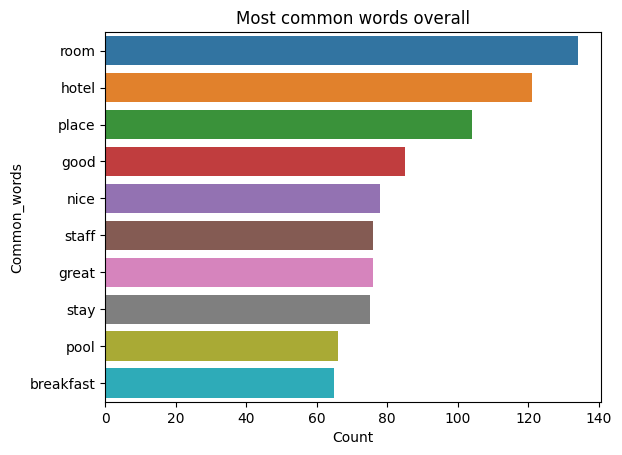

In [28]:
plt.title("Most common words overall")
ax = plotBar(temp, 'Count', 'Common_words')

# Most common words - sentiment wise


## Most common words - for positive sentiment

In [29]:
top = Counter([item for sublist in positive_text[text_col] for item in sublist])
temp = pd.DataFrame(top.most_common(number_common_words))
temp.columns = ['Common words','Count']
temp

,Common words,Count
0,hotel,117
1,room,116
2,place,99
3,good,85
4,nice,78
5,staff,76
6,great,76
7,stay,74
8,breakfast,64
9,pool,61


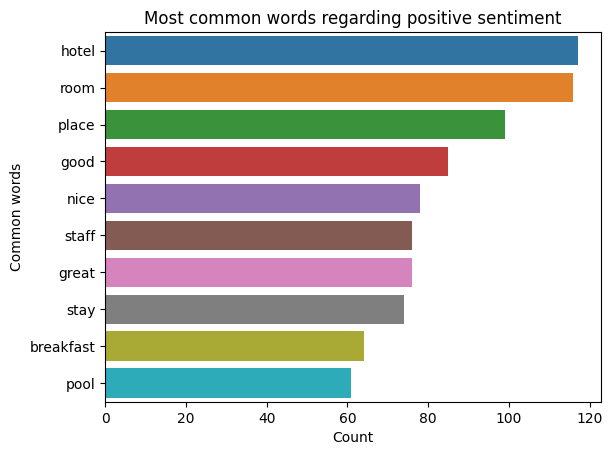

In [30]:
plt.title("Most common words regarding positive sentiment")
ax = plotBar(temp, 'Count', 'Common words')

## Most common words - for negative sentiment

In [31]:
top = Counter([item for sublist in negative_text[text_col] for item in sublist])
temp = pd.DataFrame(top.most_common(number_common_words))
temp.columns = ['Common words','Count']
temp

,Common words,Count
0,room,18
1,’,8
2,small,6
3,one,5
4,pool,5
5,way,5
6,place,5
7,food,5
8,u,4
9,hotel,4


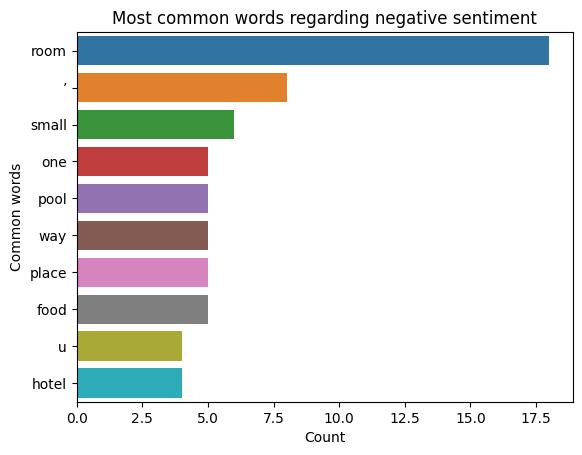

In [32]:
plt.title("Most common words regarding negative sentiment")
ax = plotBar(temp, 'Count', 'Common words')

## Most common words - for neutral sentiment

# Word clouds

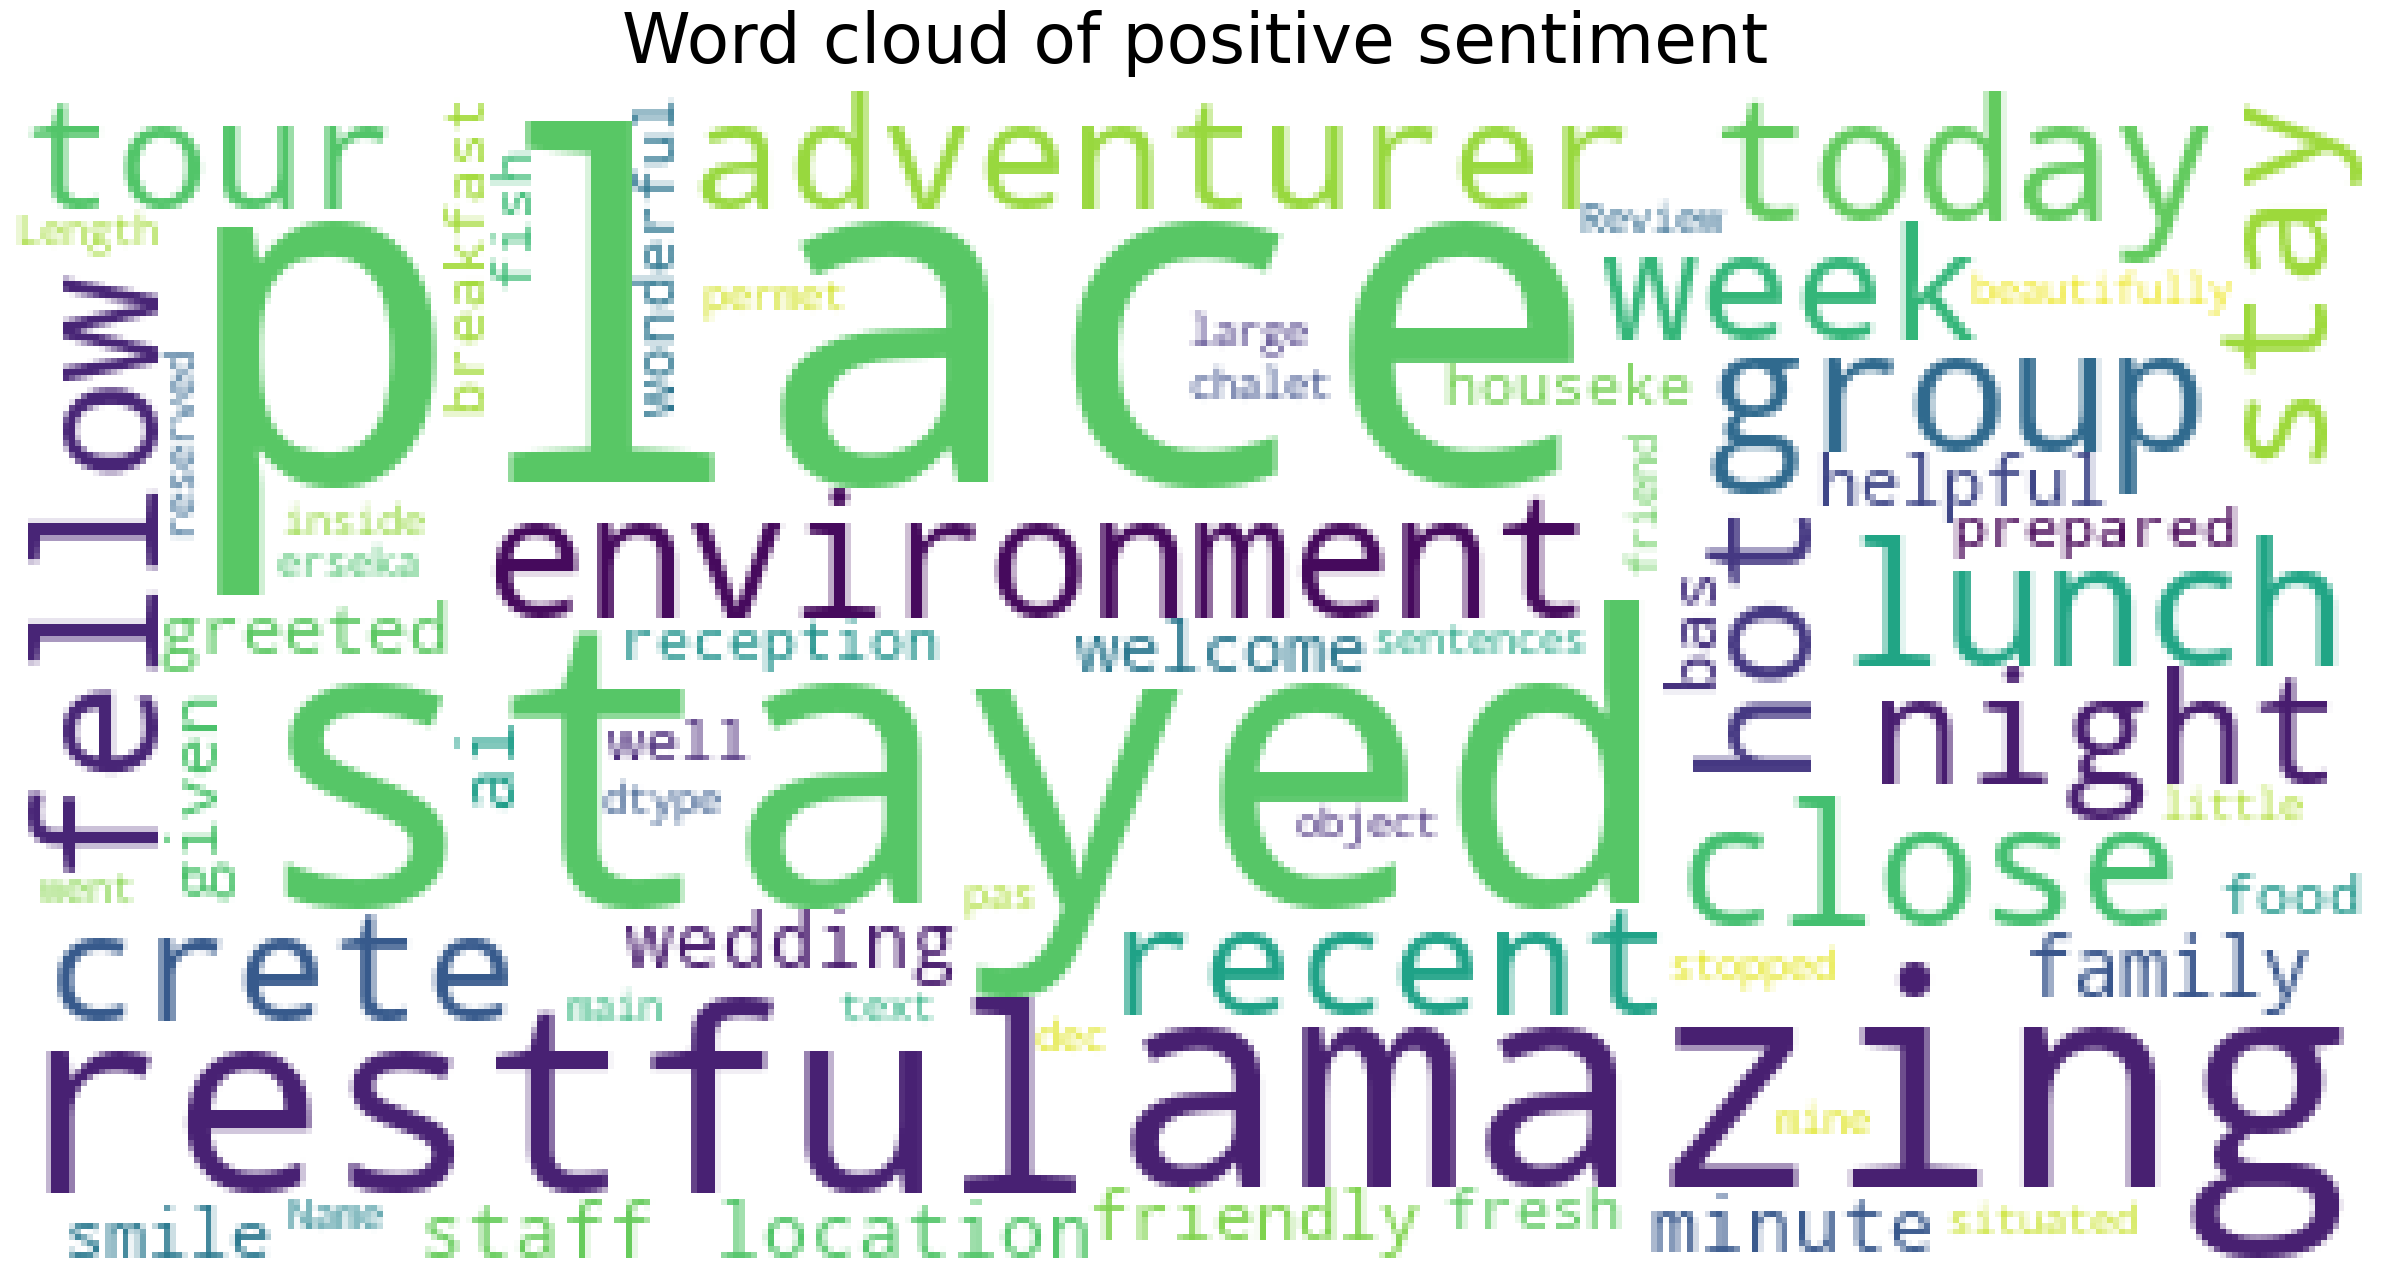

In [33]:
plotWordCloud(positive_text[text_col], color='white',
               max_font_size=80, title_size=50,
               title="Word cloud of positive sentiment")


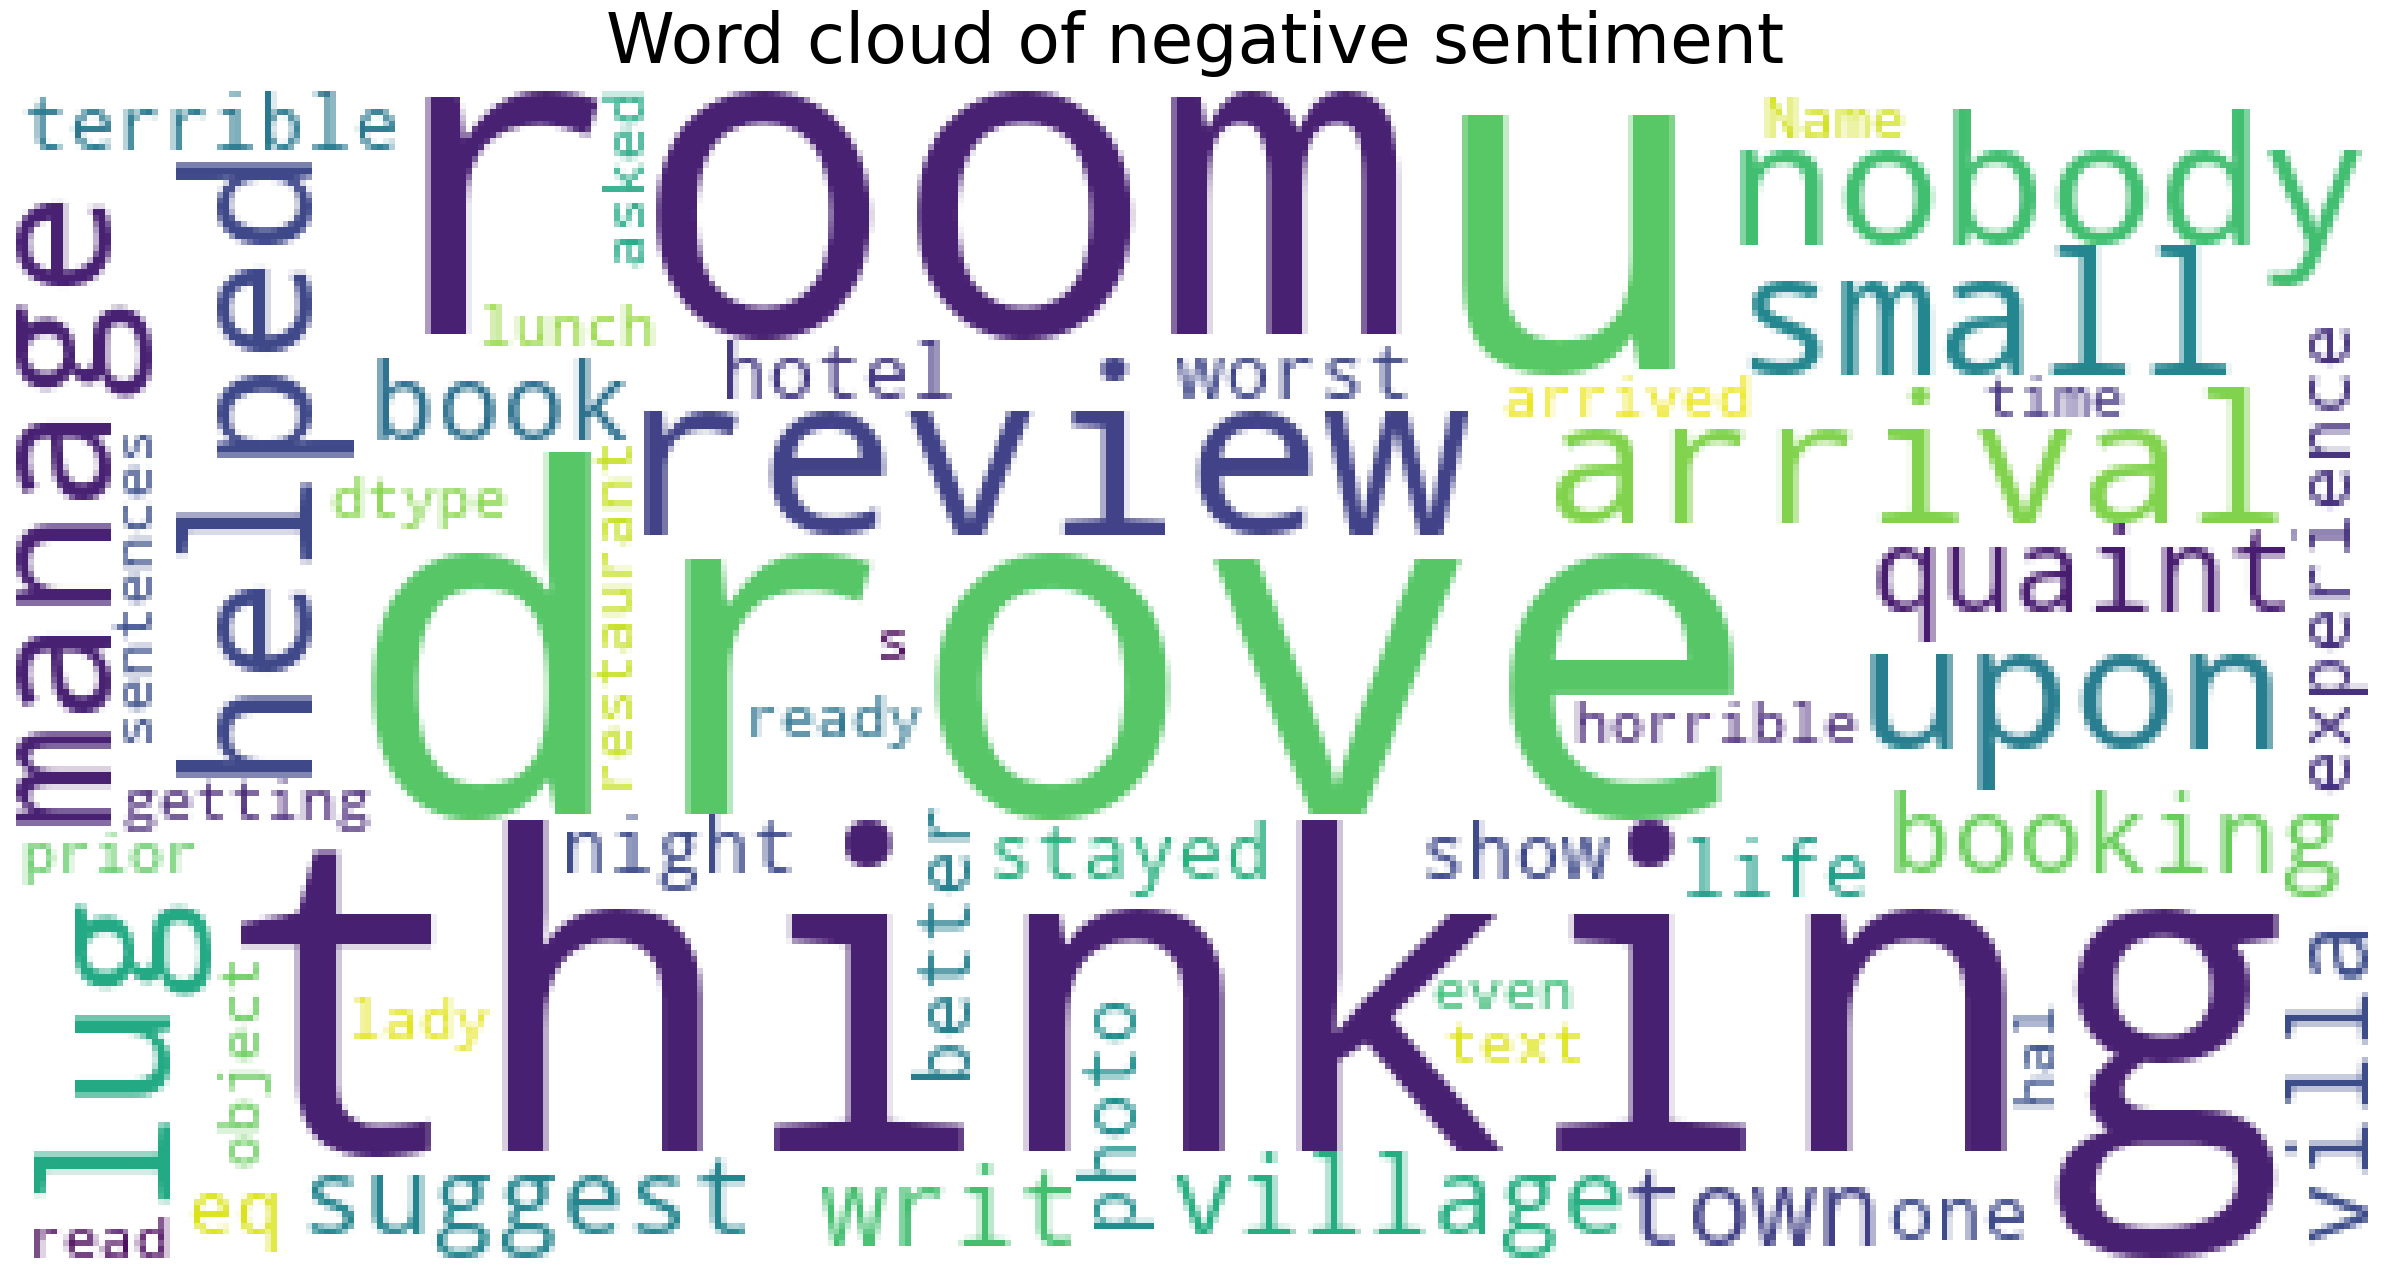

In [34]:
plotWordCloud(negative_text[text_col], color='white',
               max_font_size=80, title_size=50,
               title="Word cloud of negative sentiment")


# Save ...

In [35]:
# df.columns

In [36]:
# Save data as a parquet file

#df.write.mode("overwrite").parquet("nnnnnn")

In [ ]:
# images ...